In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import imageio.v3 as iio
from PIL import Image
import tensorflow as tf
from tensorflow import keras

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# Only print the first 10 files in each folder
for dirname, _, filenames in os.walk('/kaggle/input'):
    i = 0
    for filename in filenames:
        print(os.path.join(dirname, filename))
        i += 1
        if i >= 10:
            break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-03-05 20:35:08.426938: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 20:35:08.427044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 20:35:08.555691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testA_52_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_1_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testA_60.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_72.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_35.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testA_12_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_61_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testB_19.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/testA_5_anno.bmp
/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_12_anno.bmp


In [2]:
#  Load data
grade_path = "/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/Grade.csv"
grade = pd.read_csv(grade_path)
grade.head()

,name,patient ID,grade (GlaS),grade (Sirinukunwattana et al. 2015)
0,testA_1,4,benign,adenomatous
1,testA_10,10,benign,healthy
2,testA_11,9,benign,healthy
3,testA_12,11,malignant,poorly differentiated
4,testA_13,7,malignant,moderately differentiated


In [3]:
# Load data
train_set_size = 85
test_set_size = 80
# Image sizes
height = 512
width = 768
input_dir = "/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/"

def read_X_array(path):
    image = iio.imread(path)
    return np.array(image)/255 # Scale values between 0 and 1

def read_Y_array(path):
    image = iio.imread(path)
    image = np.array(image)
    image = np.vectorize(lambda x: x!=0)(image) # Convert to binary map
    return image

train_X = np.empty((train_set_size, height, width, 3))
train_Y = np.empty((train_set_size, height, width))
test_X = np.empty((test_set_size, height, width, 3))
test_Y = np.empty((test_set_size, height, width))

train_id = 0
test_id = 0
for sample in grade.name:
    file_X = input_dir + sample + '.bmp'
    file_Y = input_dir + sample + '_anno.bmp'
    image_X = read_X_array(file_X)
    image_Y = read_Y_array(file_Y)
    if image_X.shape <= (height, width, 3):
        pass
    elif 'train' in sample:
        train_X[train_id] = image_X[:height, :width]
        train_Y[train_id] = image_Y[:height, :width]
        train_id += 1
    elif 'test' in sample:
        test_X[test_id] = image_X[:height, :width]
        test_Y[test_id] = image_Y[:height, :width]
        test_id += 1
        
train_set_size = train_id
test_set_size = test_id
        
train_X = train_X[range(train_set_size)]
train_Y = train_Y[range(train_set_size)]
test_X = test_X[range(test_set_size)]
test_Y = test_Y[range(test_set_size)]

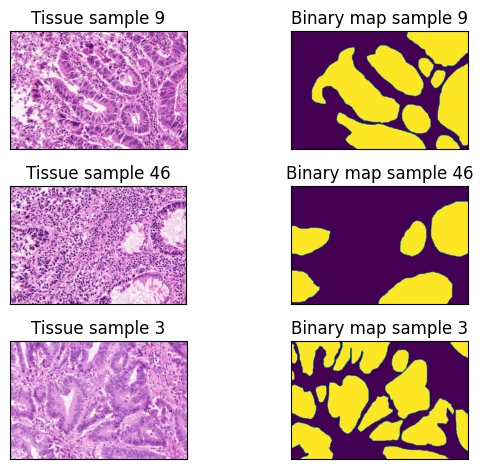

In [4]:
# Look at some examples
nr_examples = 3
random_ids = np.random.choice(np.arange(train_set_size), size=nr_examples, replace=False)
fig, axes = plt.subplots(nr_examples, 2)
for i in range(nr_examples):
    example_id = random_ids[i]
    axes[i, 0].imshow(train_X[example_id])
    axes[i, 1].imshow(train_Y[example_id])
    axes[i, 0].set_title(f'Tissue sample {example_id}')
    axes[i, 1].set_title(f'Binary map sample {example_id}')
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    
plt.tight_layout()
plt.show()

<h3>Create the Network</h3>

In [5]:
# Define common blocks
def double_conv(x, n_filters):
    x = keras.layers.Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = keras.layers.Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    return x

def down_sampling(x, n_filters):
    f = double_conv(x, n_filters)
    p = keras.layers.MaxPool2D(2)(f)
    p = keras.layers.Dropout(0.3)(p)
    return f, p

def up_sampling(x, conv_features, n_filters):
    x = keras.layers.Conv2DTranspose(n_filters, kernel_size=3, strides=2, padding='same')(x)
    x = keras.layers.concatenate([x, conv_features])
    x = keras.layers.Dropout(0.3)(x)
    x = double_conv(x, n_filters)
    return x

In [6]:
def build_unet_model():
    inputs = keras.layers.Input(shape=(height, width, 3,))
    # Down sampling
    f1, p1 = down_sampling(inputs, 32)
    f2, p2 = down_sampling(p1, 64)
    f3, p3 = down_sampling(p2, 128)
    f4, p4 = down_sampling(p3, 256)

    # Bottle Neck
    bottleneck = double_conv(p4, 512)

    # Up sampling
    u6 = up_sampling(bottleneck, f4, 256)
    u7 = up_sampling(u6, f3, 128)
    u8 = up_sampling(u7, f2, 64)
    u9 = up_sampling(u8, f1, 32)

    # outputs
    outputs = keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(u9)

    unet = keras.Model(inputs, outputs, name='U-net')
    
    return unet

In [7]:
unet_model = build_unet_model()
unet_model.summary()

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 768, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 768, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 768, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 384, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

<h3>Train Model</h3>

In [8]:
unet_model.compile(optimizer=keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics='accuracy')

In [9]:
epochs = 20
history = unet_model.fit(train_X, train_Y, epochs=epochs, batch_size=8)

Epoch 1/20


2024-03-05 20:35:47.753692: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-net/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1709670968.016129      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 109s 6s/step - loss: 0.6912 - accuracy: 0.5188
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 0.6836 - accuracy: 0.5862
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 0.6692 - accuracy: 0.5944
Epoch 4/20
10/10 [==============================] - 13s 1s/step - loss: 0.6600 - accuracy: 0.6114
Epoch 5/20
10/10 [==============================] - 13s 1s/step - loss: 0.6485 - accuracy: 0.6110
Epoch 6/20
10/10 [==============================] - 13s 1s/step - loss: 0.6816 - accuracy: 0.5432
Epoch 7/20
10/10 [==============================] - 13s 1s/step - loss: 0.6873 - accuracy: 0.5614
Epoch 8/20
10/10 [==============================] - 13s 1s/step - loss: 0.6840 - accuracy: 0.5532
Epoch 9/20
10/10 [==============================] - 13s 1s/step - loss: 0.6726 - accuracy: 0.6001
Epoch 10/20
10/10 [==============================] - 13s 1s/step - loss: 0.6618 - accuracy: 0.6064
Epoch 11/20
10/10 [==========

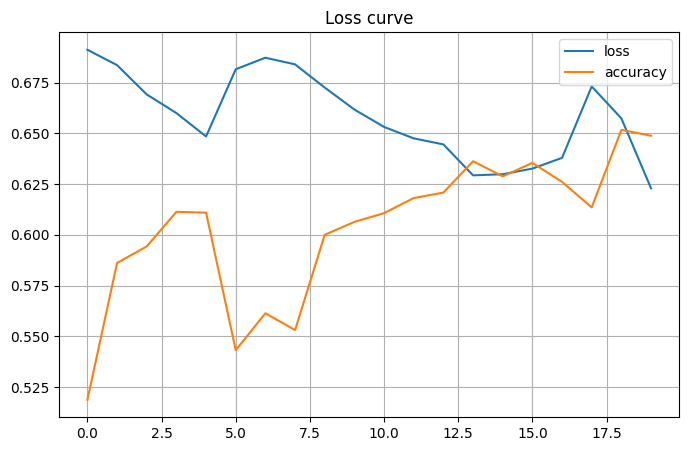

In [10]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Loss curve')
plt.savefig('/kaggle/working/loss.png')
plt.show()

In [11]:
# Save model
model_path = "/kaggle/working/conv_model.keras"
unet_model.save(model_path)

In [12]:
# Load model
model_path = "/kaggle/working/conv_model.keras"
model = keras.saving.load_model(model_path)

In [13]:
unet_model.evaluate(test_X, test_Y)

3/3 [==============================] - 62s 768ms/step - loss: 0.6785 - accuracy: 0.6005


[0.678537130355835, 0.600541353225708]

In [14]:
predictions = unet_model.predict(test_X)

3/3 [==============================] - 3s 1s/step


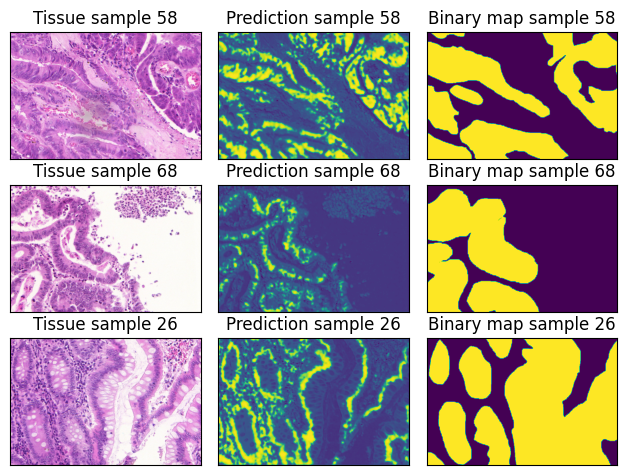

In [15]:
# Look at some examples
nr_examples = 3
random_ids = np.random.choice(np.arange(test_set_size), size=nr_examples, replace=False)
fig, axes = plt.subplots(nr_examples, 3)
for i in range(nr_examples):
    example_id = random_ids[i]
    axes[i, 0].imshow(test_X[example_id])
    axes[i, 1].imshow(predictions[example_id])
    axes[i, 2].imshow(test_Y[example_id])
    axes[i, 0].set_title(f'Tissue sample {example_id}')
    axes[i, 1].set_title(f'Prediction sample {example_id}')
    axes[i, 2].set_title(f'Binary map sample {example_id}')
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    axes[i, 2].set_xticks([])
    axes[i, 2].set_yticks([])
    
plt.tight_layout()
plt.show()

In [16]:
predictions[59]

array([[[0.53862053],
        [0.56592894],
        [0.56353676],
        ...,
        [0.63554597],
        [0.6109775 ],
        [0.57794327]],

       [[0.534231  ],
        [0.5697481 ],
        [0.58047336],
        ...,
        [0.7041307 ],
        [0.67077786],
        [0.6217527 ]],

       [[0.55942434],
        [0.6140986 ],
        [0.6304501 ],
        ...,
        [0.7571686 ],
        [0.7142928 ],
        [0.63969487]],

       ...,

       [[0.44188777],
        [0.45841408],
        [0.4724142 ],
        ...,
        [0.44594485],
        [0.4679195 ],
        [0.49695498]],

       [[0.4297087 ],
        [0.4256494 ],
        [0.42241067],
        ...,
        [0.43421194],
        [0.4645107 ],
        [0.50835794]],

       [[0.45259237],
        [0.43685752],
        [0.44202262],
        ...,
        [0.44378918],
        [0.4665611 ],
        [0.50157773]]], dtype=float32)

In [17]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_11_anno.bmp'

[[ 1  1  1 ... 12 12 12]
 [ 1  1  1 ... 12 12 12]
 [ 1  1  1 ... 12 12 12]
 ...
 [ 5  5  5 ... 15 15 15]
 [ 5  5  5 ... 15 15 15]
 [ 5  5  5 ... 15 15 15]]


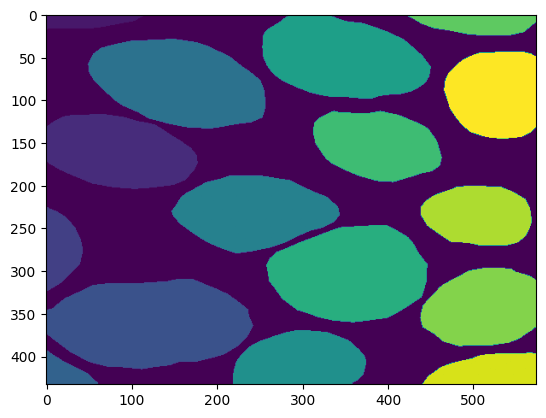

In [18]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_12_anno.bmp'
image = iio.imread(path)
print(image)
plt.imshow(image)
plt.show()

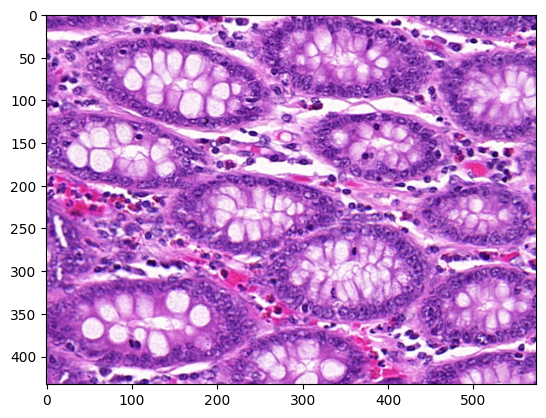

In [19]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_12.bmp'
image = iio.imread(path)
plt.imshow(image)
plt.show()

In [20]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/Grade.csv'
df = pd.read_csv(path)

In [21]:
df

,name,patient ID,grade (GlaS),grade (Sirinukunwattana et al. 2015)
0,testA_1,4,benign,adenomatous
1,testA_10,10,benign,healthy
2,testA_11,9,benign,healthy
3,testA_12,11,malignant,poorly differentiated
4,testA_13,7,malignant,moderately differentiated
...,...,...,...,...
160,train_82,2,malignant,moderately-to-poorly differentated
161,train_83,11,malignant,poorly differentiated
162,train_84,15,benign,healthy
163,train_85,10,benign,healthy


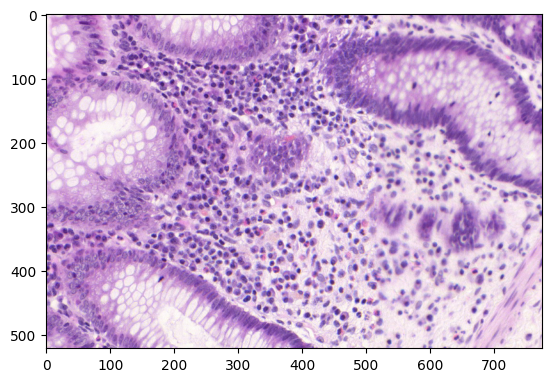

In [22]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_80.bmp'
image = iio.imread(path)
plt.imshow(image)
plt.show()

[[1 1 1 ... 7 7 7]
 [1 1 1 ... 7 7 7]
 [1 1 1 ... 7 7 7]
 ...
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]]


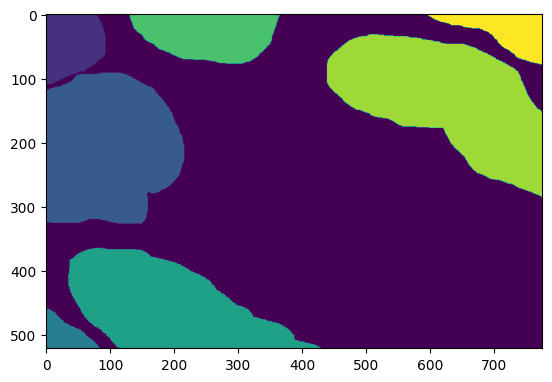

In [23]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_80_anno.bmp'
image = iio.imread(path)
print(image)
plt.imshow(image)
plt.show()

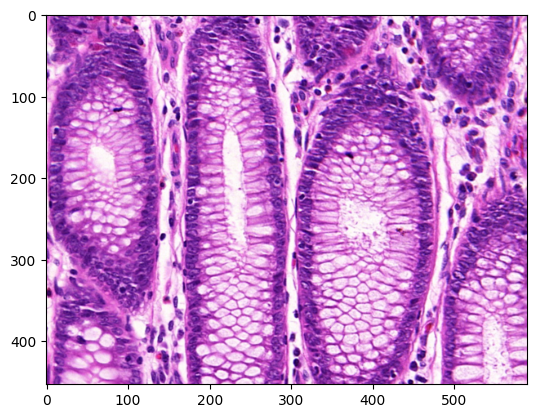

In [24]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_84.bmp'
image = iio.imread(path)
plt.imshow(image)
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 8 8 8]
 [0 0 0 ... 8 8 8]
 [0 0 0 ... 8 8 8]]


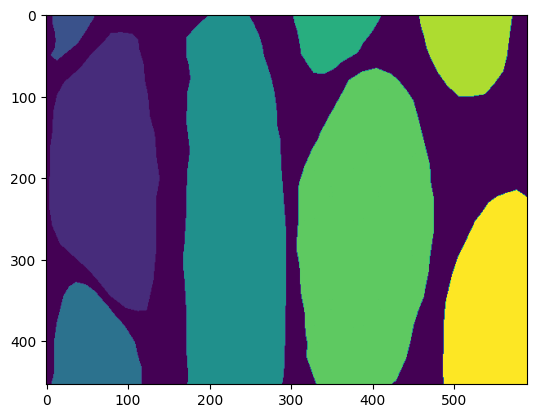

In [25]:
path = '/kaggle/input/glasmiccai2015-gland-segmentation/Warwick_QU_Dataset/train_84_anno.bmp'
image = iio.imread(path)
print(image)
plt.imshow(image)
plt.show()

In [26]:
image.shape

(453, 589)